# Gridworld example with Q-learning and Sarsa

In [1]:
# importing the necessary libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

<img src="http://drive.google.com/uc?export=view&id=18q7KL4aV6McMtaid_1Let2aGkw6d4QYn" width=45%>

In [2]:
class GridWorld:
    """
    The gridworls is a frequently used demo environment in reinforcement learning
    to try and test ideas.
    Today, we will use it to understand the concepts so far.
    
    The environment: (see image)
    * cells: the agent can step on a cell. There is exactly one cell to start from.
    This is the top left corner. There is one terminal cell where the walking ends, 
    the agent can not leave it (blue).
    * obstacles: there are cells where the agent can not step. (gray)
    * agent: it can move from one cell to an other neighboring cell. 
    Possible directions: up, down, left, right. Each transition happens with probability 1.
    * reward: after each transition the agent receives -1 point. In the terminal cell, no reward
    received anymore.
    
    Implement the environment below! You can use the implementation from the previous assignment!
    """
    def __init__(self, size, start_cell, obstacles, terminating_state):
        self.size = size
        self.start = start_cell
        self.obstacles = obstacles
        self.termin = terminating_state
        self.current_cell = self.start
    
    def reset(self):
        # ----- reset the current cell to the start cell to start again -----
        self.current_cell = self.start

    
    def transition(self, cell, action):
        # ----- IMPLEMENT FUNCTION -----
        # cell = (row, column) indices
        # action: 0 left, 1 up, 2 right, 3 down
        # returns: What will be the next state
        # Take care of the borders of the grid!
        
        # Using the same logic as done in Grid_world1
        # Checking for typical edge cases of terminal
        if cell == self.termin:
            self.current_cell = cell
            return cell
        
        # If not then let's go...
        r_next, c_next = cell[0], cell[1]  # Getting cell states in vars
        
        # if action is "left"
        if action == 0:
            if c_next != 0 :                 # Considering corner case
                c_next = c_next - 1
                
        # if action is "up"
        elif action == 1:
             if r_next != 0:                 # Considering corner case
                r_next = r_next - 1
                
        # if action is "right"
        elif action == 2:
             if c_next != self.size[1] - 1:  # Considering corner case
                c_next = c_next + 1
                
                
        # if action is "down"
        elif action == 3:
             if r_next != self.size[0] - 1:  # Considering corner case
                r_next = r_next + 1
                
        # Check after transition there is an obstacle we will not move
        if (r_next, c_next) in self.obstacles:
                self.current_cell = cell
                return cell
                
        self.current_cell = (r_next, c_next)
        
        return (r_next, c_next)

    def reward(self, cell, action):
        # ----- RETURN REWARD -----
        # -1 if not in the terminal state
        if cell != self.termin:
            return -1
        else:
            return 0
    
    
    def in_terminal(self):
        return self.current_cell == self.termin

In [3]:
class QLearning:
    """
    In this class you can implement the Q-learning algorithm.
    The algorithm will run trajectories in the environment (grid world)
    and according to the transitions ()
    """
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        # create table
        size = gridworld.size
        self.available_actions = [0,1,2,3]
        # ----- implement this -----
        self.q_table = np.zeros((len(self.available_actions), size[0], size[1]), dtype=np.float32)    # create a numpy matrix for storing the q-values for each actions and states
        # epsilon greedy
        self.eps = 0.9
        self.episode = 0
        # preformance summary
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell):
        # the update rule for q-learning
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        # ----- implement the update rule -----
        self.q_table[action, r_t, c_t] += self.alpha * ((reward) + (self.gamma * np.max( self.q_table[:, r_tp1, c_tp1])) - (self.q_table[action, r_t, c_t]))
    
    def choose_action(self, cell):
        r, c = cell
        # ----- choose the next action accroding to epsilon-greedy -----
        if np.random.uniform(0,1) < self.eps:
            action = self.available_actions[np.random.randint(0, len(self.available_actions))]
        else:
            q_values_of_state = self.q_table[:, r, c].tolist()
            action = np.argmax(q_values_of_state)
        
        return action
    
    def anneal_epsilon(self):
        # 1.5 - anneal earlier then the last episode
        # ----- Question: how does this function look like? -----
        # Answere: It helps to find out epsilon value at a particular episode of training
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  # plays an episode
        # This function is responsible for running the agent 
        # for one episode.
        # During each transition, the Q-function is updated.
        # ----- implement the missing parts -----
        cntr = 0  # counter to avoid infinite loops when the agent stucks in the grid and can not reach the terminal state
        # ----- reset the gridworld -----
        self.gridworld.reset()
        # ----- append zero at the end of sum_rewards -----
        self.sum_rewards.insert(len(self.sum_rewards),0)
        # ---- cycle until termination (end of the current episode) or an upper limit (e.g. 5000)
        while not self.gridworld.in_terminal() and cntr < 5000:
            # ----- increase the counter -----
            cntr += 1
            # ----- get the current cell -----
            cell = self.gridworld.current_cell
            # ----- choose the action -----
            action = self.choose_action(cell)
            # ----- get the reward -----
            reward = self.gridworld.reward(cell, action)
            # ----- make one transition and store -----
            next_cell = self.gridworld.transition(cell, action)
            # ----- update the q-table -----
            self.update(cell, action, reward, next_cell)
            # ----- add the reward to the last element in sum_rewards -----
            self.sum_rewards[len(self.sum_rewards)-1] += reward
        # ----- anneal epsilon -----
        self.anneal_epsilon()
        # ----- increase the episode counter -----
        self.episode += 1
    
    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            self.gridworld.transition((r, c), action)
            sum_rewards += self.gridworld.reward((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):  # depands on the number of episodes
        return self.episode > self.episodes

The main difference between **Q learning** and **Sarsa** learning is the Q-value. In Q-learning we choose an action which maximises the Q-value while in the case of Sarsa learning the policy is responsible for choosing the next action at that instant.

In [4]:
class Sarsa:
    
    def __init__(self, gridworld, gamma, alpha, episodes):
        self.gridworld = gridworld
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        # create table
        size = gridworld.size
        # ----- implement this -----
        self.available_actions = [0,1,2,3]
        self.q_table =  np.zeros((len(self.available_actions), size[0], size[1]), dtype=np.float32)   # create a numpy matrix for storing the q-values for each actions and states
        # epsilon greedy
        self.eps = 0.9
        self.episode = 0
        # preformance summary
        self.sum_rewards = []
        self.path = []
    
    def update(self, cell, action, reward, next_cell, next_action):
        # the update rule for sarsa learning
        r_t, c_t = cell  # current state
        r_tp1, c_tp1 = next_cell  # next state
        # ----- implement the update rule -----
        self.q_table[action, r_t, c_t] += self.alpha*(reward + self.gamma*np.max(self.q_table[:, r_tp1, c_tp1]) - self.q_table[next_action, r_t, c_t])
    
    def choose_action(self, cell):
        r, c = cell
        # ----- choose the next action accroding to epsilon-greedy -----
        if np.random.uniform(0,1) < self.eps:
            q_values_of_state = self.q_table[:, r, c].tolist()
            action = np.argmax(q_values_of_state)
        else:
            action = self.available_actions[np.random.randint(0, len(self.available_actions))]
        return action
    
    def anneal_epsilon(self):
        # 1.5 - anneal earlier then the last episode
        self.eps = max(0, self.eps * (1 - self.episode / self.episodes * 1.5))
    
    def one_episode(self):  # plays an episode
        # ----- implement this -----
        # use the same logic like in Q-learning
        # be aware that this is an on-policy algorithm!
        # ----------------------------------------------------------------------
        # Question: Can you explain concisely what is the main difference
        # between on-policy and off-policy?
        
        # Answer: Precisely defining, the difference between on policy and off policy, the main diff lies in target and behavioural policies which are not the same
        # behavioural policy, is the policy that is responsible for choosing the next action during sampling.
        # target policy, is basically policy we want to learn. This provides highest possible return.
        # Sarsa is on-policy learning
        # Q-learning is off-policy learning
        #---------------------------------------------------------------------------
        
        cntr = 0  # counter to avoid infinite loops when the agent stucks in the grid and can not reach the terminal state
        # ----- reset the gridworld -----
        self.gridworld.reset()
        # ----- append zero at the end of sum_rewards -----
        self.sum_rewards.insert(len(self.sum_rewards),0)
        # ---- cycle until termination (end of the current episode) or an upper limit (e.g. 5000)
        while not self.gridworld.in_terminal() and cntr < 5000:
            # ----- increase the counter -----
            cntr += 1
            # ----- get the current cell -----
            cell = self.gridworld.current_cell
            # ----- choose the action -----
            action = self.choose_action(cell)
            # ----- get the reward -----
            reward = self.gridworld.reward(cell, action)
            # ----- make one transition and store -----
            next_cell = self.gridworld.transition(cell, action)
            # ----- update the q-table -----
            next_action = self.choose_action(next_cell)
            self.update(cell, action, reward, next_cell, next_action)
            # ----- add the reward to the last element in sum_rewards -----
            self.sum_rewards[len(self.sum_rewards)-1] += reward
        # ----- anneal epsilon -----
        self.anneal_epsilon()
        # ----- increase the episode counter -----
        self.episode += 1
        
    
    def trajectory(self):
        self.gridworld.reset()
        self.path = []
        sum_rewards = 0
        itr = 0
        while not self.gridworld.in_terminal() and itr < 20:
            r, c = self.gridworld.current_cell
            action = np.argmax(self.q_table[:, r, c])
            self.gridworld.transition((r, c), action)
            sum_rewards += self.gridworld.reward((r, c), action)
            itr += 1
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):
        return self.episode > self.episodes

In [5]:
def plot_learning_curve(ql):
    values = ql.sum_rewards
    x = list(range(len(values)))
    y = values
    plt.plot(x, y, 'ro')
    plt.show()

## Q learning

-66
-38
-44
-156
-22
-105
-38
-144
-14
-183
-67
-58
-57
-116
-58
-97
-26
-164
-34
-54
-126
-54
-86
-42
-47
-44
-60
-28
-50
-35
-58
-21
-42
-23
-30
-20
-100
-26
-29
-22
-61
-18
-30
-53
-84
-9
-20
-43
-33
-50
-16
-9
-37
-15
-59
-67
-17
-25
-14
-40
-22
-56
-12
-33
-23
-23
-16
-22
-56
-10
-51
-28
-11
-44
-35
-17
-27
-23
-17
-61
-32
-21
-15
-15
-13
-22
-22
-20
-26
-10
-40
-16
-13
-35
-18
-13
-13
-36
-48
-10
-40
-34
-9
-11
-17
-15
-18
-16
-32
-18
-17
-30
-16
-11
-14
-27
-11
-35
-14
-9
-41
-16
-14
-11
-42
-13
-8
-21
-18
-25
-17
-18
-11
-25
-14
-41
-8
-27
-11
-13
-16
-15
-10
-11
-18
-11
-9
-35
-14
-15
-17
-11
-40
-18
-12
-25
-10
-16
-15
-8
-20
-13
-16
-10
-8
-12
-16
-11
-8
-16
-43
-21
-8
-8
-11
-21
-8
-14
-9
-11
-15
-9
-14
-43
-14
-12
-13
-10
-18
-13
-8
-10
-9
-20
-8
-12
-9
-20
-10
-17
-22
-11
-16
-8
-30
-13
-13
-9
-11
-13
-8
-11
-8
-14
-9
-10
-16
-11
-29
-12
-9
-8
-9
-8
-13
-12
-10
-12
-11
-12
-11
-9
-11
-8
-18
-11
-22
-14
-9
-14
-9
-36
-8
-9
-9
-10
-10
-10
-8
-8
-10
-12
-10
-12
-14
-11
-11
-

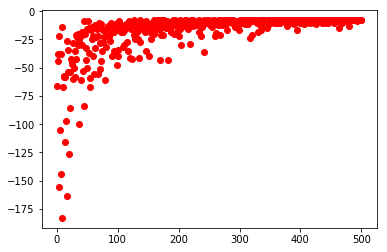

In [6]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
alpha = 0.1
episodes = 500

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = QLearning(gw, gamma, alpha, episodes)  # ----- try both of them -----
#solver = Sarsa(gw, gamma, alpha, episodes)

while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]
    print(sum_rewards)

sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)

*Observations*
<div class="alert alert-block alert-warning">

We see the reward getting stabilised after some iterations over time in the case of Q-learning

</div>

## Sarsa Learning

-55
-45
-53
-29
-80
-113
-128
-121
-113
-90
-114
-53
-136
-33
-133
-45
-58
-41
-91
-58
-103
-56
-26
-51
-97
-82
-27
-30
-31
-15
-86
-74
-207
-31
-29
-45
-25
-53
-113
-14
-24
-146
-114
-49
-86
-25
-244
-111
-31
-31
-150
-37
-105
-28
-140
-115
-35
-37
-195
-144
-27
-52
-385
-90
-117
-294
-229
-138
-112
-30
-105
-179
-42
-128
-289
-106
-143
-433
-48
-68
-209
-24
-24
-167
-117
-122
-121
-26
-35
-460
-186
-216
-52
-114
-181
-208
-245
-163
-268
-48
-70
-88
-169
-18
-61
-34
-148
-216
-129
-98
-25
-53
-98
-78
-103
-15
-178
-41
-118
-660
-29
-160
-179
-101
-242
-94
-528
-272
-51
-59
-153
-39
-63
-28
-38
-206
-101
-80
-93
-52
-35
-125
-42
-270
-211
-35
-61
-15
-161
-107
-39
-54
-294
-118
-235
-83
-264
-96
-41
-38
-84
-89
-46
-44
-196
-60
-38
-83
-461
-61
-109
-206
-65
-52
-27
-483
-23
-107
-164
-331
-44
-239
-198
-49
-187
-137
-29
-34
-167
-200
-68
-122
-61
-22
-31
-81
-48
-69
-297
-186
-171
-57
-61
-105
-107
-282
-88
-136
-82
-97
-67
-130
-26
-47
-188
-372
-306
-82
-122
-96
-57
-118
-51
-119
-8

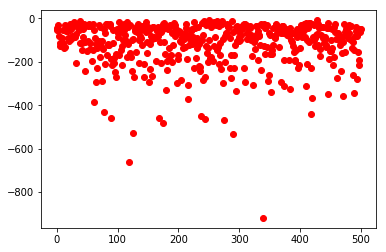

In [9]:
solver = Sarsa(gw, gamma, alpha, episodes)
while not solver.is_learning_finished():
    solver.one_episode()
    sum_rewards = solver.sum_rewards[-1]
    print(sum_rewards)

sum_rewards = solver.trajectory()
print(sum_rewards)
plot_learning_curve(solver)

*Observations*
<div class="alert alert-block alert-warning">

In the case of Sarsa learning we see the reward stability is uniform, although some minor fluctuations occur with iterations

</div>